<a href="https://colab.research.google.com/github/Justawayx/microbe_tracking/blob/master/image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/image_segmentation/RNN_centroids

/content/drive/.shortcut-targets-by-id/1oL1IKgNdUkjyUG9U8GsIIiZwuLk7-0r1/image_segmentation/RNN_centroids


In [ ]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from skimage import filters
from skimage.color import rgb2gray
import cv2
import glob
from matplotlib import pyplot as plt
from scipy import ndimage, signal

wd = '/content/drive/My Drive/image_segmentation/RNN_centroids/'

In [ ]:
tf.compat.v1.disable_eager_execution()


def Distance_MSE(max_centroids):
    def loss(y_pred, y_true):
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids*2))
        y_pred = tf.keras.backend.repeat(y_pred, max_centroids)
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids, max_centroids, 2))
        y_pred2 = tf.keras.backend.permute_dimensions(y_pred, pattern=(0,2,1,3))

        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids*2))
        y_true = tf.keras.backend.repeat(y_true, max_centroids)
        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids, max_centroids, 2))
        y_true = tf.keras.backend.permute_dimensions(y_true, pattern=(0, 2, 1, 3))

        distance1 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_true),axis=3)
        distance2 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_pred2),axis=3)

        prob = tf.keras.activations.exponential(-1 * distance1/tf.keras.backend.sum(distance1))
        prob2 = tf.keras.backend.sum(tf.keras.activations.exponential(-1 * distance2),axis=1)

        return tf.reduce_mean(prob * distance1)
    return loss


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))


def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def Modified_dice_loss():
    def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

    return loss


def develop_features_v2(folder_path):
    img_dir = folder_path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        img = cv2.imread(f1)
        img_gray = rgb2gray(img) #convert to grayscale
        threshold_val = filters.threshold_otsu(img_gray) #threashold image
        threshold_img = img_gray < threshold_val
        data.append(threshold_img)
    # return np.array(data)
    arr_data = np.array(data)
    m, n, o = arr_data.shape
    return np.reshape(arr_data, (m,n,o,1))


def develop_labels(folder_path, max_centroids = 0):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    padded_frames = list()
    for file in files:
        print(file)
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            for line in f:
                x, y = line.split()
                print(int(x),int(y))
                frame.append((int(x), int(y)))
                cur_max += 1

            frame = np.array(frame, 'uint16')
            frames.append(frame)
            max_centroids = max(cur_max, max_centroids)

    for frame in frames:
        frame = np.pad(frame, ((0, max_centroids - np.shape(frame)[0]), (0, 0)), constant_values=((0,0),(0,0)))
        padded_frames.append(frame)

    return np.array(padded_frames, dtype='uint16'), max_centroids


def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(inputs)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(conv_layer)

    return pool


def createModel(image_dim, max_centroids, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(4, block)
    block = code_block(4, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), activation='relu',padding='same')(block)
    flatten = tf.keras.layers.Flatten()(conv)
    dense = tf.keras.layers.Dense(max_centroids * 2)(flatten)
    reshape = tf.keras.layers.Reshape((max_centroids, 2))(dense)

    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Distance_MSE(max_centroids), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

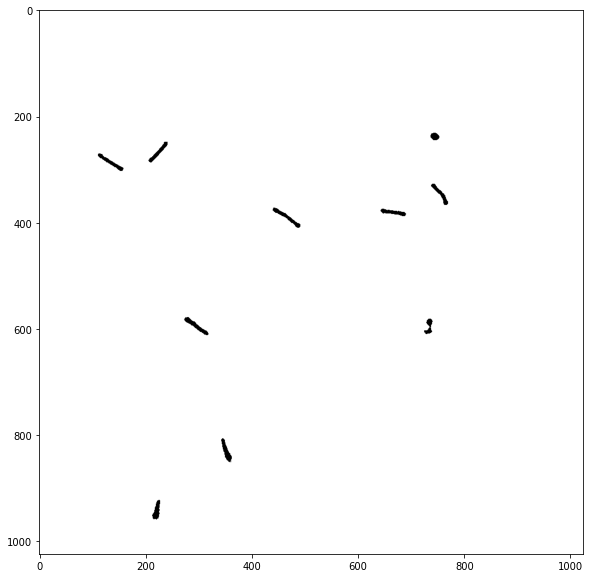

In [ ]:
# Current preprocessing

from skimage import filters

img = imgs[0]
img_gray = np.uint8(rgb2gray(img)*255) #convert to grayscale
# threshold_img = cv2.fastNlMeansDenoising(img_gray, None, h=12)

threshold_img = filters.gaussian(img_gray)
threshold_img = filters.laplace(threshold_img)

# threshold_img = np.uint8(normalize_intensity(threshold_img, 255, 0))
# threshold_img = cv2.fastNlMeansDenoising(threshold_img, None, h=12)

threshold_val = filters.threshold_yen(img_gray) #threashold image
threshold_img = img_gray < threshold_val

threshold_img = filters.median(threshold_img)

#more filters
threshold_img = np.array(threshold_img, dtype='float32')
plt.figure(figsize=(10,10))
plt.imshow(threshold_img,cmap='gray')

In [ ]:
def normalize_intensity(img, normMax, normMin):
  normRange = normMax - normMin
  imgMax, imgMin = img.max(), img.min()
  imgRange = imgMax - imgMin
  img_norm = (img - imgMin) * (normRange/imgRange) + normMin
  return img_norm

In [ ]:
max_centroids = 0

# ====================
# Image preprocessing
# ====================

img_dir = wd + 'newFrames/' # Directory of all images 
files = sorted([f for f in os.listdir(img_dir)])
# Read images (cv2.imread returns RGB numpy.ndarray)
imgs = [cv2.imread(img_dir + file) for file in files]

# Intensity normalization (linear)
imgs_norm = []
for img in imgs:
  img_norm = normalize_intensity(img, 1.0, 0.0)
  imgs_norm.append(img_norm)

Shape: (300, 300)


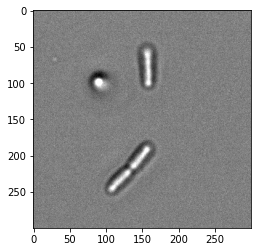

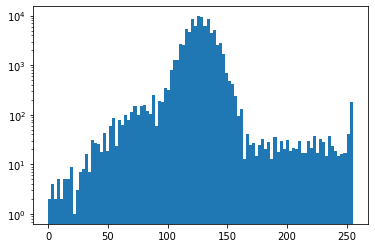

In [ ]:
# Visualize one example

img = np.uint8(imgs_norm[9][600:900,50:350]*255) # float64 not supported
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
plt.imshow(img_gray, cmap='gray')
print("Shape: " + str(img_gray.shape))

def plot_hist(img): # Examine intensity histogram
  plt.figure()
  plt.hist(img.ravel(), bins = 100, log = True)
  plt.show()

plot_hist(img_gray)

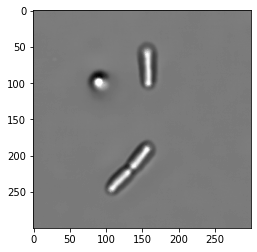

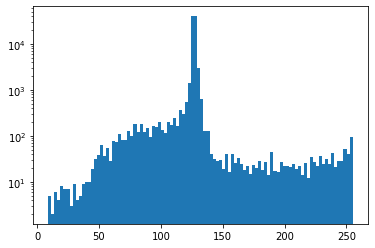

In [ ]:
# Try background denoising
img_f1 = cv2.fastNlMeansDenoising(img_gray, None, h=12)
plt.imshow(img_f1, cmap='gray')
plot_hist(img_f1)

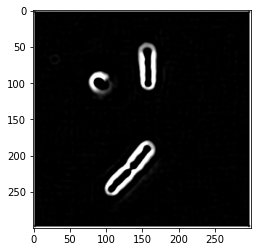

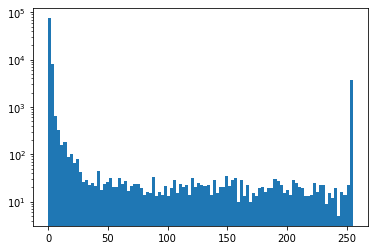

In [ ]:
# Try Gaussian and Laplacian

def Gaussian(size,sigma):
  yi, xi = np.mgrid[0:size, 0:size] - np.floor(size/2) # Assumes odd size
  G = (1/(2*np.pi*(sigma**2)))*np.e**(-1*((xi**2)+(yi**2))/(2*(sigma**2)))
  return G

gfilter = Gaussian(9, 2)
img_f2 = signal.convolve2d(img_f1, gfilter, mode='same')

img_f3 = cv2.Laplacian(img_f2, cv2.CV_8U, ksize=5)

plt.imshow(img_f3, cmap='gray')
plot_hist(img_f3)

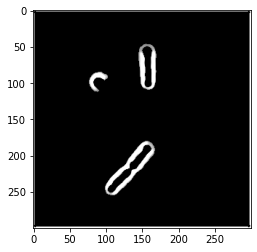

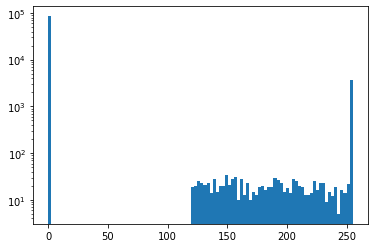

In [ ]:
# Try Otsu threshold to turn background to 0s

th_otsu = filters.threshold_otsu(img_f3)
img_f3[img_f3 <= th_otsu] = 0

plt.imshow(img_f3, cmap='gray')
plot_hist(img_f3)

In [ ]:
# Try these things on all images

def preprocess(img):
  img_8u = np.uint8(img*255) # Range 0-255
  img_gray = cv2.cvtColor(img_8u, cv2.COLOR_BGR2GRAY) # Convert to grayscale
  img_f1 = cv2.fastNlMeansDenoising(img_gray, None, h=12) # Denoise
  img_f2 = signal.convolve2d(img_f1, gfilter, mode='same') # Gaussian filter
  img_f3 = cv2.Laplacian(img_f2, cv2.CV_8U, ksize=5) # Laplacian filter
  th_otsu = filters.threshold_otsu(img_f3) # Otsu threshold for background
  img_f3[img_f3 <= th_otsu] = 0
  return img_f3

data = []
progress = 0

for img in imgs_norm:
    img_pp = preprocess(img)
    data.append(img_pp)
    progress += 1
    if progress % 10 == 0:
      print("Done processing %s images" % progress)

Done processing 10 images
Done processing 20 images
Done processing 30 images
Done processing 40 images
Done processing 50 images
Done processing 60 images
Done processing 70 images
Done processing 80 images
Done processing 90 images
Done processing 100 images
Done processing 110 images
Done processing 120 images
Done processing 130 images
Done processing 140 images
Done processing 150 images
Done processing 160 images
Done processing 170 images
Done processing 180 images
Done processing 190 images
Done processing 200 images


There are 201 images with shape (1024, 1024)


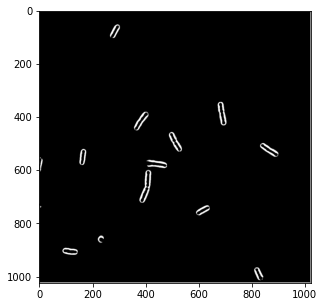

In [ ]:
# Spot check

print("There are " + str(len(data)) + " images with shape " + str(data[0].shape))
plt.figure(figsize=(5,5))
plt.imshow(data[100], cmap='gray')

In [ ]:
# Prepare input features

arr_data = np.array(data)
m, n, o = arr_data.shape
image_dim = n, o
features = np.reshape(arr_data, (m,n,o,1))
print(features.shape)
files = sorted([f for f in os.listdir(img_dir)])
# Read images (cv2.imread returns RGB numpy.ndarray)
imgs = [cv2.imread(img_dir + file) for file in files]

(201, 1024, 1024, 1)


In [ ]:
import scipy

def euclidean_distance(loc1, loc2):
  return np.linalg.norm(loc1-loc2)

# centroid_locs, ploc should be numpy arrays
def min_edist_to_centroid(centroid_locs, ploc):
  ploc = ploc.reshape(1,2)
  diffs = scipy.spatial.distance.cdist(ploc,centroid_locs)
  return diffs.min()

In [ ]:
def centroids_to_pmap(img, centroid_locs):
  h, w = img.shape
  frame = np.zeros(img_ex.shape)
  indices = np.array(list(np.ndindex(h, w)))
  centroid_locs = np.array(centroid_locs)
  for index in indices:
    x, y = index
    frame[y, x] = min_edist_to_centroid(centroid_locs, index)
  return frame

In [ ]:
# Try making Pmap for one image

img_ex = arr_data[1]
h, w = img_ex.shape
centroid_locs = []
with open(centroid_dir + files[1], 'r') as f:
  for line in f:
    x, y = line.split()
    centroid_locs.append((int(x), int(y)))

pmap = centroids_to_pmap(img_ex, centroid_locs)

[(93, 236), (692, 366), (737, 274), (748, 371), (377, 644), (529, 378), (772, 567), (229, 930), (367, 755), (237, 266), (704, 611)]


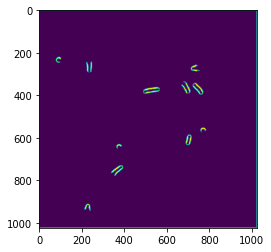

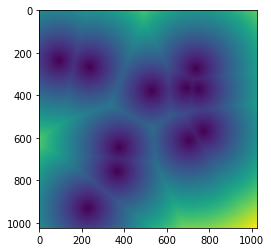

In [ ]:
plt.figure()
plt.imshow(img_ex)
print(centroid_locs)
plt.figure()
plt.imshow(pmap)

In [ ]:
# Silly int string formatter

def int_to_fixlen_str(intnum, strlen):
  result = str(intnum)
  len_diff = strlen - len(result)
  for i in range(len_diff):
    result = '0' + result
  return result

'00005'

In [ ]:
# Grab centroid labels

pmap_dir = wd + 'centroidPMaps/'
centroid_dir = wd + 'newCentroids/'
files = sorted([f for f in os.listdir(centroid_dir)])

frames = []

for i in range(0,len(files)):

  # Grab centroid labels
  centroid_locs = []
  with open(centroid_dir + files[i], 'r') as f:
    for line in f:
      x, y = line.split()
      centroid_locs.append((int(x), int(y)))
  
  # Create PMap frame for each image
  # where intensities represent distance to closest centroid
  img = arr_data[i]
  frame = centroids_to_pmap(img, centroid_locs)
  frames.append(frame)
  fname = pmap_dir + 'PA14_WT_pMQ72_0ara_20190416_JD_WS_t50400-CC-' + int_to_fixlen_str(i+1,3) + '.jpg'
  cv2.imwrite(fname, frame)

In [ ]:
# Already generated Pmaps, load them up

pmap_dir = wd + 'centroidPMaps/'
files = sorted([f for f in os.listdir(pmap_dir)])
frames = [cv2.cvtColor(cv2.imread(pmap_dir + file), cv2.COLOR_BGR2GRAY) for file in files]

In [ ]:
# Prepare input labels

arr_frames = np.array(frames)
m, n, o = arr_frames.shape
labels = np.reshape(arr_frames, (m,n,o,1))
print(labels.shape)

(201, 1024, 1024, 1)


In [ ]:
# Ok, distances are too large, process more

for frame in frames:
  frame[frame>10]=10

arr_frames = np.array(frames)
m, n, o = arr_frames.shape
labels = np.reshape(arr_frames, (m,n,o,1))

In [ ]:
# Try model from https://github.com/jolohan/nuclei-detection/

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def mean_squared_diff(y_true, y_pred):
  diff_squared = (y_true-y_pred)**2
  return tf.math.reduce_mean(diff_squared)

def get_unet(IMG_WIDTH=1024,IMG_HEIGHT=1024,IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss=mean_squared_diff, metrics=[mean_squared_diff])
    return model

Using TensorFlow backend.


In [ ]:
print(labels[0,:,:,0])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [237 237 235 ... 255 255 255]
 [238 237 236 ... 255 255 255]
 [238 237 236 ... 255 255 255]]


In [ ]:
u_net = get_unet()
u_net.summary()
#u_net.fit(features,labels,batch_size=2,epochs=5, validation_split=0.1)

# Yea I have no idea what I'm doing...

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024, 1024, 1 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 1024, 1024, 1 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 1024, 1024, 1 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

5/5 [==============================] - 2s 382ms/step


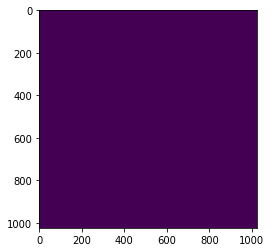

In [ ]:
test_img = arr_data[0:5].reshape(5,1024,1024,1)
real_pmap = np.array(frames[0:5]).reshape(5,1024,1024,1)
test_pmap = u_net.predict(test_img,verbose=1)

plt.imshow(test_pmap[0,:,:,0])

In [ ]:
# Faster R-CNN? Only want region proposal
# https://arxiv.org/pdf/1506.01497.pdf

In [ ]:
# Check labels
'''
check_centroid_dir = wd + 'checkCentroids/'

for i in range(len(data)):
  img_ex, img_ex_centroids = data[i], labels[i,:,:]
  for x, y in img_ex_centroids:
    img_ex[y-5:y+5,x-5:x+5] = 255
  fname = 'PA14_WT_pMQ72_0ara_20190416_JD_WS_t50400-CC-' + str(i+1) + '.jpg'
  cv2.imwrite(check_centroid_dir + fname, img_ex)
'''

"\ncheck_centroid_dir = wd + 'checkCentroids/'\n\nfor i in range(len(data)):\n  img_ex, img_ex_centroids = data[i], labels[i,:,:]\n  for x, y in img_ex_centroids:\n    img_ex[y-5:y+5,x-5:x+5] = 255\n  fname = 'PA14_WT_pMQ72_0ara_20190416_JD_WS_t50400-CC-' + str(i+1) + '.jpg'\n  cv2.imwrite(check_centroid_dir + fname, img_ex)\n"

In [ ]:
from matplotlib import pyplot as plt

img = features[0,:,:,0]
pred = np.reshape((model.predict(img.reshape(1,1024,1024,1))), (128, 2))
for i in range(128):
    if pred[i,0] > 0 and pred[i, 0] < 1023 and pred[i,1] >= 1 and pred[i,1] < 1023:
        x = int(round(pred[i,0]))
        y = int(round(pred[i,1]))
        img[x,y] = 255
        img[x - 1, y] = 0
        img[x + 1, y] = 0
        img[x, y - 1] = 0
        img[x, y + 1] = 0

plt.imshow(img, cmap='gray')

for i in range(128):
    print(labels[0,i,:,], pred[i,:])

In [ ]:
# tutorial stuff https://elitedatascience.com/keras-tutorial-deep-learning-in-python

import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


In [ ]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# Define model architecture
model = Sequential()
 
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

NameError: ignored

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.1984 - accuracy: 0.9392
Epoch 2/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.0836 - accuracy: 0.9759
Epoch 3/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.0668 - accuracy: 0.9807
Epoch 4/10
60000/60000 [==============================] - 11s 181us/step - loss: 0.0538 - accuracy: 0.9833
Epoch 5/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.0488 - accuracy: 0.9848
Epoch 6/10
60000/60000 [==============================] - 11s 175us/step - loss: 0.0426 - accuracy: 0.9867
Epoch 7/10
60000/60000 [==============================] - 10s 175us/step - loss: 0.0367 - accuracy: 0.9890
Epoch 8/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.0343 - accuracy: 0.9887
Epoch 9/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.0312 - accuracy: 0.9899
Epoch 10/10
60000/60000 [============

In [ ]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 1s 74us/step


[0.02964257982142251, 0.9919000267982483]